In [1]:
! pip install nltk

In [2]:
import nltk
# Download the punctuations
nltk.download('punkt')
# Download the stop words corpus
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sathv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sathv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sathv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sathv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 

In [4]:
df=pd.read_csv('data.csv')
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
df1=df[['Review text','Ratings']]

In [6]:
df1.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [7]:
pd.unique(df['Ratings'])


array([4, 1, 3, 5, 2], dtype=int64)

<Axes: xlabel='Ratings', ylabel='count'>

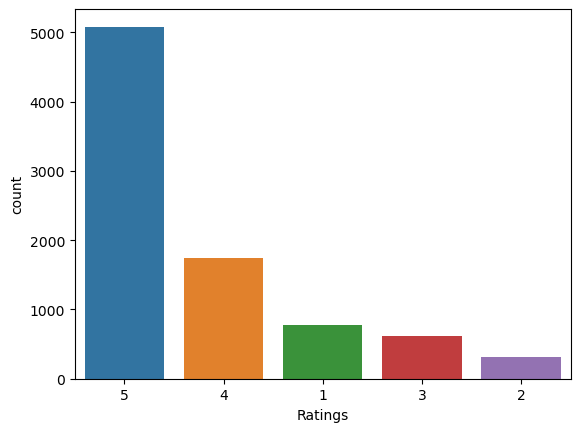

In [8]:
sns.countplot(data=df1, 
              x='Ratings', 
              order=df1.Ratings.value_counts().index)

In [51]:
# rating label(final) 
pos_neg = [] 
for i in range(len(df1['Ratings'])): 
    if df1['Ratings'][i] >= 4: 
        pos_neg.append(1) 
    else: 
        pos_neg.append(0) 
  
df1['label'] = pos_neg 

In [52]:
df1 = df1.rename(columns={'Review text': 'reviews'})


In [53]:
df1=df1.dropna(subset=['reviews'])

In [54]:
df1.head()

,reviews,Ratings,label
0,"Nice product, good quality, but price is now r...",4,1
1,They didn't supplied Yonex Mavis 350. Outside ...,1,0
2,Worst product. Damaged shuttlecocks packed in ...,1,0
3,"Quite O. K. , but nowadays the quality of the...",3,0
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1,0


In [55]:
df1["label"].value_counts()

label
1    6823
0    1687
Name: count, dtype: int64

In [56]:
df1["label"].value_counts(normalize=True)

label
1    0.801763
0    0.198237
Name: proportion, dtype: float64

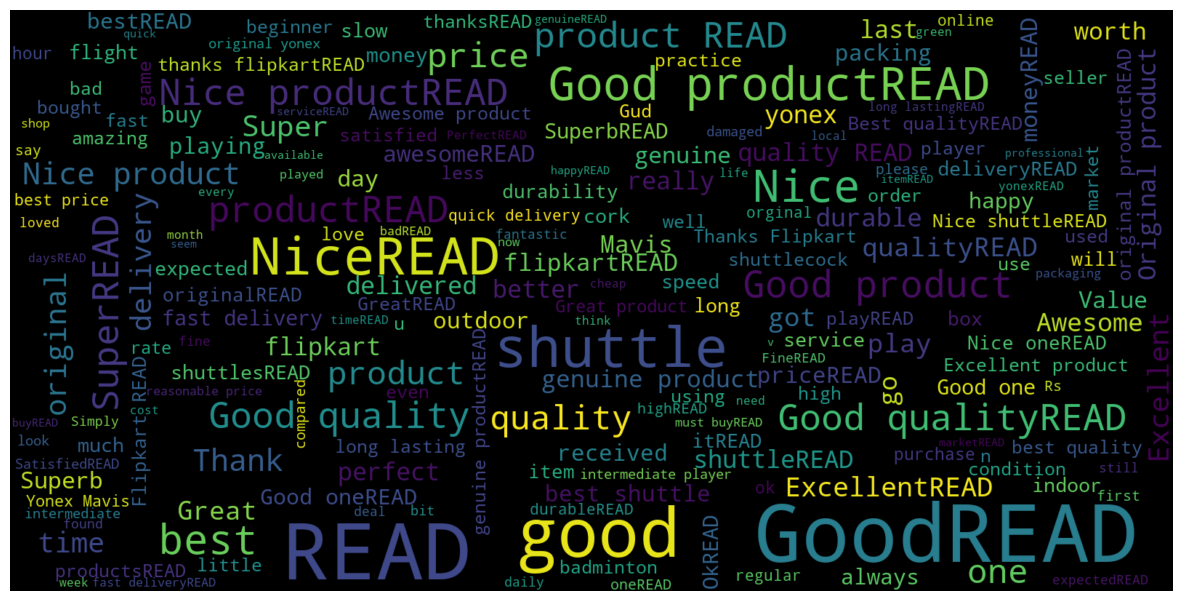

In [57]:
consolidated = ' '.join( 
    word for word in df1['reviews'][df1['label'] == 1].astype(str)) 
wordCloud = WordCloud(width=1600, height=800, 
                      random_state=21, max_font_size=110) 
plt.figure(figsize=(15, 10)) 
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear') 
plt.axis('off') 
plt.show() 

In [58]:
#step1 identify i/p & o/p
X=df1.reviews
Y=df1.label
print(X.shape,Y.shape)

(8510,) (8510,)


In [59]:
#step2 split train & test data
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    stratify=Y, 
                                                    random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6808,) (6808,)
(1702,) (1702,)


In [60]:
# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()


### Data preprocessing on train data

In [61]:
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def preprocess_data(data): # data is a string of text
    # This text contains a lot of READ MORE
    data = data.replace("READ MORE", " ")
    
    # Remove punctuation and numbers.
    data = "".join([char for char in data if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    data = data.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(data)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)


preprocessed_review = preprocess_text(X_train.values) 
X_train = preprocessed_review

In [62]:
# instantiate a vectorizer
vect = CountVectorizer(preprocessor=preprocess_data)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)


print(X_train_dtm.shape)

Wall time: 1.78 s
(6808, 2573)


preprocessed_review = preprocess_text(X_test.values) 
X_test = preprocessed_review

In [63]:
# transforming testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(1702, 2573)


cv = TfidfVectorizer(max_features=2500) 
X_train_dtm = cv.fit_transform(X_train)  # Fit and transform on training data
X_test_dtm = cv.transform(X_test)        # 

In [64]:
X_train_dtm.shape

(6808, 2573)

### Data preprocesing on text data

cv = TfidfVectorizer(max_features=2500) 
#X_test_dtm = cv.transform(X_test).toarray()
X_test_dtm.shape


In [65]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=0) 
model.fit(X_train_dtm,y_train) 
  
#testing the model 
pred = model.predict(X_train_dtm) 
print(accuracy_score(y_train,pred))

0.9513807285546416


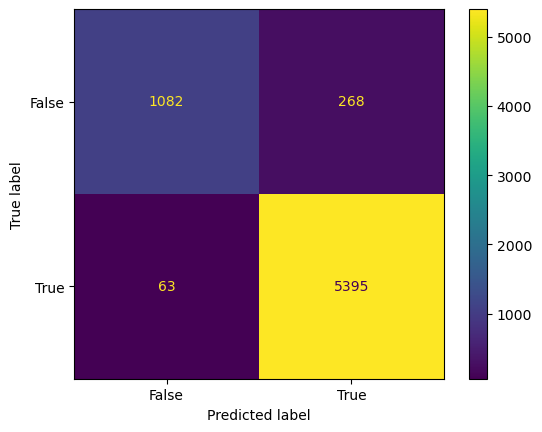

In [66]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,pred) 
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,  
                                            display_labels = [False, True]) 
  
cm_display.plot() 
plt.show()

In [67]:
print(y_test.shape)


(1702,)


In [68]:
y_test_pred = model.predict(X_test_dtm)
metrics.accuracy_score(y_test, y_test_pred)

0.8490011750881316

Text(0.5, 23.52222222222222, 'Predicted')

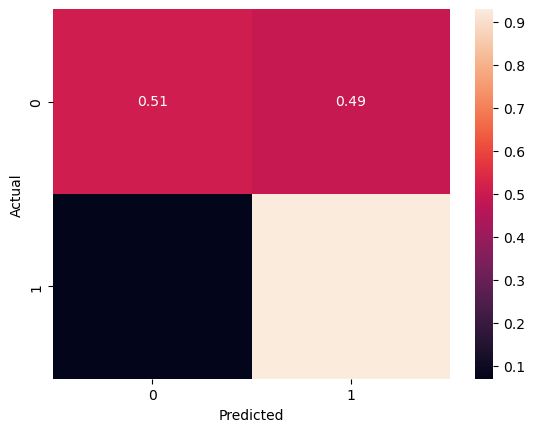

In [69]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [70]:


print("Train Score (F1 Score):", metrics.f1_score(y_train, pred))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred))

Train Score (F1 Score): 0.9702364895243233
Test Score (F1 Score): 0.9083125222975383


In [71]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

In [72]:
import joblib
from joblib import Memory

import os

In [73]:
%time X_train_clean = X_train.apply(lambda doc: preprocess_data(doc))

Wall time: 1.65 s


In [74]:
%time X_test_clean = X_test.apply(lambda doc: preprocess_data(doc))

Wall time: 435 ms


In [75]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 4.56 s
Score on Test Data:  0.927921623512946
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 21.8 s
Score on Test Data:  0.9165517241379311
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Wall time: 3min 41s
Score on Test Data:  0.9120879120879121


C:\Users\sathv\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [76]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1500)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.5,
                                    penalty='elasticnet', solver='saga'))])



********** naive_bayes **********
Wall time: 4.89 ms
Test Score (F1) 0.927921623512946


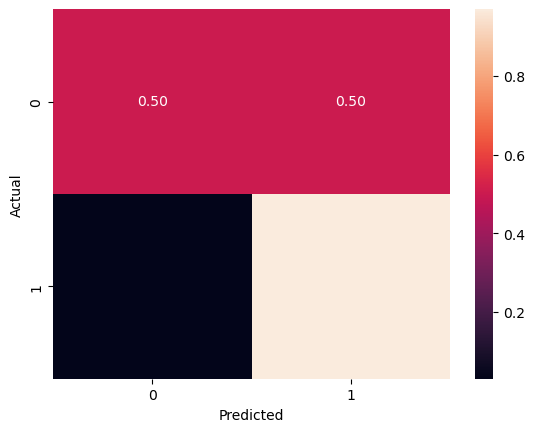

Model Size: 148390 Bytes
********** decision_tree **********
Wall time: 6.13 ms
Test Score (F1) 0.9165517241379311


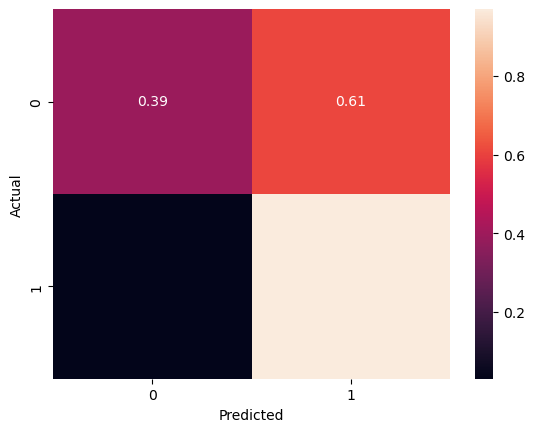

Model Size: 88028 Bytes
********** logistic_regression **********
Wall time: 4 ms
Test Score (F1) 0.9120879120879121


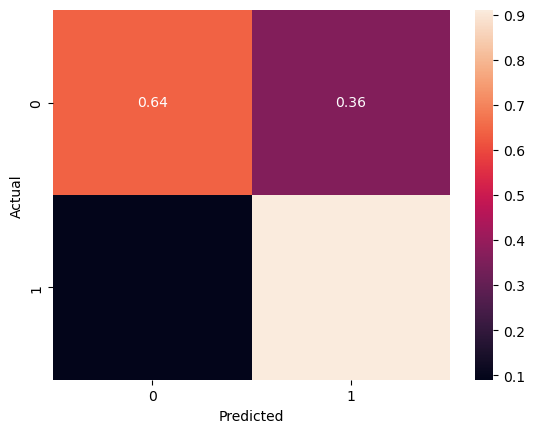

Model Size: 86681 Bytes


In [77]:

for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    os.makedirs('best_models', exist_ok=True)
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    %time y_test_pred = model.predict(X_test_clean)
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred))
    
    cm = metrics.confusion_matrix(y_test, y_test_pred)
    actual = np.sum(cm, axis=1).reshape(-1, 1)
    cmn = np.round(cm/actual, 2)

    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

In [81]:
model = joblib.load('best_models/naive_bayes.pkl')
review_data = ["""I purchased an induction cooker with high hopes for a convenient and efficient cooking experience, but unfortunately, my experience has been far from satisfactory. Within just four months of regular use, the appliance abruptly stopped working, leaving me frustrated and disappointed.

Despite my initial excitement about the induction cooker's features, the abrupt failure was a major letdown. I promptly registered a complaint, hoping for a swift resolution to the issue. However, to my dismay, I have received no response from the company or any customer service representative.

The lack of communication and assistance in addressing the problem has left me feeling abandoned as a customer. It's disheartening to invest in a product only to have it malfunction so quickly, and the absence of support from the company has only added to the frustration.

In addition to the inconvenience caused by the sudden breakdown, the lack of responsiveness from customer service reflects poorly on the company's commitment to customer satisfaction. A reliable and responsive support system is crucial, especially when customers encounter issues with their purchases.

In conclusion, while the induction cooker initially showed promise, its short lifespan and the lack of customer support have left me regretting my purchase. I would caution potential buyers to thoroughly research a product's durability and the company's customer service reputation before making a similar investment
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [82]:
model = joblib.load('best_models/decision_tree.pkl')
review_data = ["""I purchased an induction cooker with high hopes for a convenient and efficient cooking experience, but unfortunately, my experience has been far from satisfactory. Within just four months of regular use, the appliance abruptly stopped working, leaving me frustrated and disappointed.

Despite my initial excitement about the induction cooker's features, the abrupt failure was a major letdown. I promptly registered a complaint, hoping for a swift resolution to the issue. However, to my dismay, I have received no response from the company or any customer service representative.

The lack of communication and assistance in addressing the problem has left me feeling abandoned as a customer. It's disheartening to invest in a product only to have it malfunction so quickly, and the absence of support from the company has only added to the frustration.

In addition to the inconvenience caused by the sudden breakdown, the lack of responsiveness from customer service reflects poorly on the company's commitment to customer satisfaction. A reliable and responsive support system is crucial, especially when customers encounter issues with their purchases.

In conclusion, while the induction cooker initially showed promise, its short lifespan and the lack of customer support have left me regretting my purchase. I would caution potential buyers to thoroughly research a product's durability and the company's customer service reputation before making a similar investment
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Positive


In [83]:
model = joblib.load('best_models/logistic_regression.pkl')
review_data = ["""I purchased an induction cooker with high hopes for a convenient and efficient cooking experience, but unfortunately, my experience has been far from satisfactory. Within just four months of regular use, the appliance abruptly stopped working, leaving me frustrated and disappointed.

Despite my initial excitement about the induction cooker's features, the abrupt failure was a major letdown. I promptly registered a complaint, hoping for a swift resolution to the issue. However, to my dismay, I have received no response from the company or any customer service representative.

The lack of communication and assistance in addressing the problem has left me feeling abandoned as a customer. It's disheartening to invest in a product only to have it malfunction so quickly, and the absence of support from the company has only added to the frustration.

In addition to the inconvenience caused by the sudden breakdown, the lack of responsiveness from customer service reflects poorly on the company's commitment to customer satisfaction. A reliable and responsive support system is crucial, especially when customers encounter issues with their purchases.

In conclusion, while the induction cooker initially showed promise, its short lifespan and the lack of customer support have left me regretting my purchase. I would caution potential buyers to thoroughly research a product's durability and the company's customer service reputation before making a similar investment
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Negative


##### due to baised data we can see poor perfomance using decision tree but naive_bayes is working good with new data

In [90]:
model = joblib.load('best_models/naive_bayes.pkl')
review_data = ["""The product is horrible. Received 5 minutes ago and tried to use this but it was not working, completely faulty item. I have purchased this item on the basis of review. However i would suggest you not to waste your hard money on this item instead of purchase the branded item and it will work properly. The seller also said in the product description that the warranty is of 20 years but when i opened this package it was having warranty of only year. Trust me guys this product is not worth the penny.
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [89]:
model = joblib.load('best_models/decision_tree.pkl')
review_data = ["""The product is horrible. Received 5 minutes ago and tried to use this but it was not working, completely faulty item. I have purchased this item on the basis of review. However i would suggest you not to waste your hard money on this item instead of purchase the branded item and it will work properly. The seller also said in the product description that the warranty is of 20 years but when i opened this package it was having warranty of only year. Trust me guys this product is not worth the penny.
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Positive


In [88]:
model = joblib.load('best_models/logistic_regression.pkl')
review_data = ["""The product is horrible. Received 5 minutes ago and tried to use this but it was not working, completely faulty item. I have purchased this item on the basis of review. However i would suggest you not to waste your hard money on this item instead of purchase the branded item and it will work properly. The seller also said in the product description that the warranty is of 20 years but when i opened this package it was having warranty of only year. Trust me guys this product is not worth the penny.
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Positive
